## *Tools & libraries*

In [11]:
import numpy as np
import pandas as pd
import gensim
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## *Get the data*

In [12]:
data = pd.read_csv("cleaned_hm.csv")
#data = pd.read_csv("1220.csv")
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


## *Basic data cleaning*

In [13]:
data["predicted_category"].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [14]:
data["num_sentence"].value_counts()

1     83711
2      9542
3      3847
4      1624
5       821
6       336
7       183
8       107
10       68
9        61
11       35
13       26
12       21
16       17
18       17
14       14
17       14
19       12
21       10
15        7
23        7
25        7
26        5
24        5
22        4
30        3
31        3
20        3
29        3
27        2
32        2
40        2
37        2
69        1
60        1
34        1
42        1
44        1
48        1
35        1
46        1
51        1
56        1
53        1
58        1
28        1
45        1
Name: num_sentence, dtype: int64

In [15]:
# deleting happy moments with more than 10 sentences
mod_data = data.loc[data['num_sentence'] <= 10]
mod_data["predicted_category"].value_counts()

affection           34020
achievement         33966
enjoy_the_moment    11115
bonding             10700
leisure              7458
nature               1839
exercise             1202
Name: predicted_category, dtype: int64

In [16]:
## categorical to numerical
encode = {
    "affection" : 0,
    "achievement"  : 1,       
    "bonding" : 2,    
    "enjoy_the_moment" : 3,     
    "leisure"  : 4,    
    "nature" : 5,    
    "exercise" : 6
}

In [17]:
mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])
mod_data.head()

C:\Users\USER\AppData\Local\Temp/ipykernel_10052/862238804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,0
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,0
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,6
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,0


## *Data cleaning for NLP*

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

happy_lines = list()
lines = mod_data["cleaned_hm"].values.tolist()

for line in lines:
    # tokenize the text
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove non alphabetic characters
    words = [word for word in stripped if word.isalpha()]
    happy_lines.append(words)
    
happy_lines[0:5]

[['i',
  'went',
  'on',
  'a',
  'successful',
  'date',
  'with',
  'someone',
  'i',
  'felt',
  'sympathy',
  'and',
  'connection',
  'with'],
 ['i',
  'was',
  'happy',
  'when',
  'my',
  'son',
  'got',
  'marks',
  'in',
  'his',
  'examination'],
 ['i', 'went', 'to', 'the', 'gym', 'this', 'morning', 'and', 'did', 'yoga'],
 ['we',
  'had',
  'a',
  'serious',
  'talk',
  'with',
  'some',
  'friends',
  'of',
  'ours',
  'who',
  'have',
  'been',
  'flaky',
  'lately',
  'they',
  'understood',
  'and',
  'we',
  'had',
  'a',
  'good',
  'evening',
  'hanging',
  'out'],
 ['i',
  'went',
  'with',
  'grandchildren',
  'to',
  'butterfly',
  'display',
  'at',
  'crohn',
  'conservatory']]

In [20]:
# pip install nltk

## *Train-test split*

In [21]:
validation_split = 0.2
max_length = 55

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  mod_data['predicted_category'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

unique tokens - 26138
vocab_size - 26139


In [22]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (80240, 55)
Shape of y_train: (80240, 7)
Shape of X_test_pad: (20060, 55)
Shape of y_test: (20060, 7)


## *GloVe Model*

In [26]:
embedding_index = {}
embedding_dim = 100
glove_dir = "."
f = open(os.path.join(glove_dir, '.\glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [27]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [29]:
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(7, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_glove.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 100)           2613900   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 2,631,155
Trainable params: 17,255
Non-trainable params: 2,613,900
_________________________________________________________________
None


In [37]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

In [48]:
history_glove = model_glove.fit(X_train_pad, y_train, batch_size=32, epochs=11, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/5
2508/2508 [==============================] - 49s 20ms/step - loss: 0.3368 - accuracy: 0.8747 - val_loss: 0.3321 - val_accuracy: 0.8772
Epoch 2/5
2508/2508 [==============================] - 50s 20ms/step - loss: 0.3322 - accuracy: 0.8759 - val_loss: 0.3303 - val_accuracy: 0.8780
Epoch 3/5
2508/2508 [==============================] - 50s 20ms/step - loss: 0.3281 - accuracy: 0.8780 - val_loss: 0.3216 - val_accuracy: 0.8807
Epoch 4/5
2508/2508 [==============================] - 51s 20ms/step - loss: 0.3248 - accuracy: 0.8804 - val_loss: 0.3181 - val_accuracy: 0.8799
Epoch 5/5
2508/2508 [==============================] - 51s 20ms/step - loss: 0.3231 - accuracy: 0.8781 - val_loss: 0.3179 - val_accuracy: 0.8803


In [49]:
history_glove.history

{'loss': [0.3368256986141205,
  0.3322465121746063,
  0.3281109929084778,
  0.32484331727027893,
  0.3230521082878113],
 'accuracy': [0.874688446521759,
  0.8758848309516907,
  0.8779661059379578,
  0.8803838491439819,
  0.8781156539916992],
 'val_loss': [0.3321174681186676,
  0.3302508592605591,
  0.32160842418670654,
  0.31811124086380005,
  0.31788474321365356],
 'val_accuracy': [0.8771684765815735,
  0.8779661059379578,
  0.8806580305099487,
  0.8798604011535645,
  0.8802592158317566]}

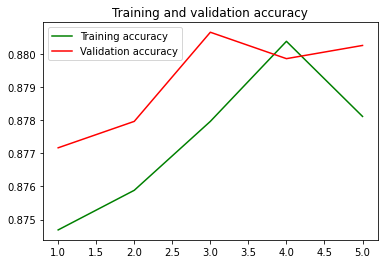

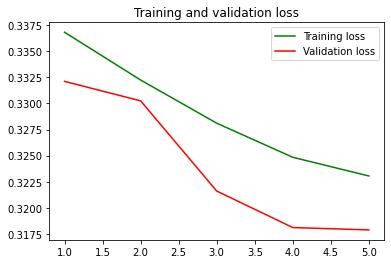

In [50]:
# Plot results
import matplotlib.pyplot as plt

acc = history_glove.history['accuracy']
val_acc = history_glove.history['val_accuracy']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## *Word2Vec model*

In [51]:
embedding_dim = 300
word2vec_dir = "D:\Pre-trained Word Vectors\GoogleNews-vectors-negative300"
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load_word2vec_format(os.path.join(word2vec_dir, 'GoogleNews-vectors-negative300.bin'), binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Pre-trained Word Vectors\\GoogleNews-vectors-negative300\\GoogleNews-vectors-negative300.bin'

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [ ]:
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec.add(Dense(7, activation='softmax'))

model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec.summary())

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

In [ ]:
history_word2vec = model_word2vec.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), callbacks=[checkpoint], verbose=1)

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['acc']
val_acc = history_word2vec.history['val_acc']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()